##Setup
To run DeepChem within Colab, you'll need to run the following installation commands. This will take about 5 minutes to run to completion and install your environment. You can of course run this tutorial locally if you prefer. In that case, don't run these cells since they will download and install Anaconda on your local machine.

In [1]:
# If the notebook stops running after this cell, just start by running the next one
!pip install -q condacolab
import condacolab
condacolab.install()


⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:28
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
!mamba install -c conda-forge rdkit &>/dev/null

In [3]:
!pip install rdkit-pypi -qqq

     |████████████████████████████████| 22.5 MB 1.4 MB/s 


In [4]:
# Install deepchem 
!pip install --pre deepchem &>/dev/null

In [5]:
from rdkit import Chem
import deepchem as dc

# DeepChem
Here, we are going to show you how you can use DeepChem to obtain two different representations of molecules, and then use those representations to build models that predict the solubility of these molecules in water. 

## Working With Data in DeepChem
Like the tf.data module in TensorFlow, DeepChem comes with special objects and functions that make working with chemistry datasets for deep learning much easier. It also comes with many preloaded and preprocessed datasets just like TensorFlow and Keras. Below, we will load in the Delaney dataset included in the large chemistry databank MoleculeNet. 

In [6]:
# Load in the delaney dataset
tasks, datasets, transformers = dc.molnet.load_delaney()
train_dataset, valid_dataset, test_dataset = datasets

# Let's take a look at what we have
print(test_dataset)

<DiskDataset X.shape: (113, 1024), y.shape: (113, 1), w.shape: (113, 1), ids: ['c1cc2ccc3cccc4ccc(c1)c2c34' 'Cc1cc(=O)[nH]c(=S)[nH]1'
 'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 ' ...
 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43' 'Cc1occc1C(=O)Nc2ccccc2'
 'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '], task_names: ['measured log solubility in mols per litre']>


There's a lot of information there, so let's start at the beginning.  It begins with the label "DiskDataset".  Dataset is an abstract class.  It has a few subclasses that correspond to different ways of storing data.

- `DiskDataset` is a dataset that has been saved to disk.  The data is stored in a way that can be efficiently accessed, even if the total amount of data is far larger than your computer's memory.
- `NumpyDataset` is an in-memory dataset that holds all the data in NumPy arrays.  It is a useful tool when manipulating small to medium sized datasets that can fit entirely in memory.
- `ImageDataset` is a more specialized class that stores some or all of the data in image files on disk.  It is useful when working with models that have images as their inputs or outputs.

Now let's consider the contents of the Dataset.  Every Dataset stores a list of *samples*.  Very roughly speaking, a sample is a single data point.  In this case, each sample is a molecule.  In other datasets a sample might correspond to an experimental assay, a cell line, an image, or many other things.  For every sample the dataset stores the following information.

- The *features*, referred to as `X`.  This is the input that should be fed into a model to represent the sample.
- The *labels*, referred to as `y`.  This is the desired output from the model.  During training, it tries to make the model's output for each sample as close as possible to `y`.
- The *weights*, referred to as `w`.  This can be used to indicate that some data values are more important than others.
- An *ID*, which is a unique identifier for the sample.  This can be anything as long as it is unique.  Sometimes it is just an integer index, but in this dataset the ID is a SMILES string describing the molecule.

Notice that `X`, `y`, and `w` all have 113 as the size of their first dimension.  That means this dataset contains 113 samples.

The final piece of information listed in the output is `task_names`.  Some datasets contain multiple pieces of information for each sample.  For example, if a sample represents a molecule, the dataset might record the results of several different experiments on that molecule.  This dataset has only a single task: "measured log solubility in mols per litre".  Also notice that `y` and `w` each have shape (113, 1).  The second dimension of these arrays usually matches the number of tasks.

Let's take a look at what is actually in the dataset...

In [7]:
for X, y, w, id in test_dataset.itersamples():
    print(X, "\n", y, "\n", w, "\n", id)
    break # just look at first line

[0. 0. 0. ... 0. 0. 0.] 
 [-1.60114461] 
 [1.] 
 c1cc2ccc3cccc4ccc(c1)c2c34


The preprocessed dataset loaded here already contains molecular fingerprints when we load it in. However, for the mini-project you will have to do the preprocessing yourself to get the SMILES strings into the representation you want to use for your model.

Let's see how we can use DeepChem to obtain fingerprint and graph representations of these molecules from their SMILES stings. More information can be found in [this](https://deepchem.readthedocs.io/en/latest/get_started/tutorials.html) guide, which you should definetly take a look at if you choose to do this as your mini=project!

## Molecules as Fingerprints
### Extended-Connectivity Fingerprints
Chemical fingerprints are vectors of 1s and 0s that represent the presence or absence of specific features in a molecule. Extended-connectivity fingerprints (ECFPs) are a class of featurizations that combine several useful features. They take molecules of arbitrary size and convert them into fixed-length vectors. This is important because lots of models require their inputs to all have exactly the same size. ECFPs let you take molecules of many different sizes and use them all with the same model. ECFPs are also very easy to compare. You can simply take the fingerprints for two molecules and compare corresponding elements. The more elements that match, the more similar the molecules are. Finally, ECFPs are fast to compute.

Each element of the fingerprint vector indicates the presence or absence of a particular molecular feature, defined by some local arrangement of atoms. The algorithm begins by considering every atom independently and looking at a few properties of the atom: its element, the number of covalent bonds it forms, etc. Each unique combination of these properties is a feature, and the corresponding elements of the vector are set to 1 to indicate their presence. The algorithm then works outward, combining each atom with all the ones it is bonded to. This defines a new set of larger features, and the corresponding elements of the vector are set. The most common variant of this technique is the ECFP4 algorithm, which allows for sub-fragments to have a radius of two bonds around a central atom.

ECFPs do have one important disadvantage: the fingerprint encodes a large amount of information about the molecule, but some information does get lost. It is possible for two different molecules to have identical fingerprints, and given a fingerprint, it is impossible to uniquely determine what molecule it came from. The RDKit library provides utilities for computing ECFP4 fingerprints for molecules:

Let's see how we can convert SMILES strings to ECFPs using DeepChem (it's really easy!)

In [8]:
# Get the smiles strings of the data
smiles_only = test_dataset.ids
print(smiles_only[1:5]) # just a list of strings

['Cc1cc(=O)[nH]c(=S)[nH]1' 'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 '
 'c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45' 'C1=Cc2cccc3cccc1c23']


In [9]:
# Convert to ECFP fingerprint
featurizer = dc.feat.CircularFingerprint(size=1024)
ecfp_data = featurizer.featurize(smiles_only)

In [10]:
# Now our data is represented as 1024 vectors
print(ecfp_data.shape)

(113, 1024)


## Molecules as Graphs
###Graph Theory Basics

A graph ${G}$ is defined by a set of vertices (or nodes) $V$ and a set of edges $E$ that connect one vertex to another. You can conviniently represent all the edges at once with an adjacency matrix $A$. $A_{ij}$ is 1 if $V_i$ and $V_j$ are connected. Graph is called undirected if $A_{ij}=A_{ji}=1$ for all (i, j) pairs. Here are examples of undirected and directed graphs:

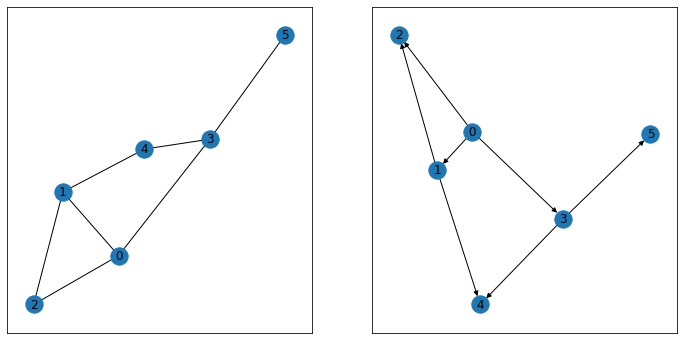

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
A = np.array([[0, 1, 1, 1, 0, 0],
              [1, 0, 1, 0, 1, 0],
              [1, 1, 0, 0, 0, 0],
              [1, 0, 0, 0, 1, 1],
              [0, 1, 0, 1, 0, 0],
              [0, 0, 0, 1, 0, 0]])
B = np.array([[0, 1, 1, 1, 0, 0],
              [0, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 1],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0]])
G_undirected = nx.from_numpy_matrix(A)
G_directed = nx.from_numpy_matrix(B, create_using=nx.DiGraph)
fig, ax = plt.subplots(1,2, figsize=(12, 6))
nx.draw_networkx(G_undirected, ax=ax[0])
nx.draw_networkx(G_directed, ax=ax[1])

### Graph Neural Networks

In its most general from, we assume data will have **graph-wide features $u$**, **node features $v_i$**, and **edge features $e_{ij}$**. And at each layer, we do the following:


1.   Update edge feature $e_{ij}$ 
2.   Aggregate node i's neighbor node features $v_j$ using edge $e_{ij}$
3.   Update node i's feature $v_i$ using aggregated feature from 2
4.   Update graph-wide feature $u$ using updated edge/node features 

These steps are pictured below:

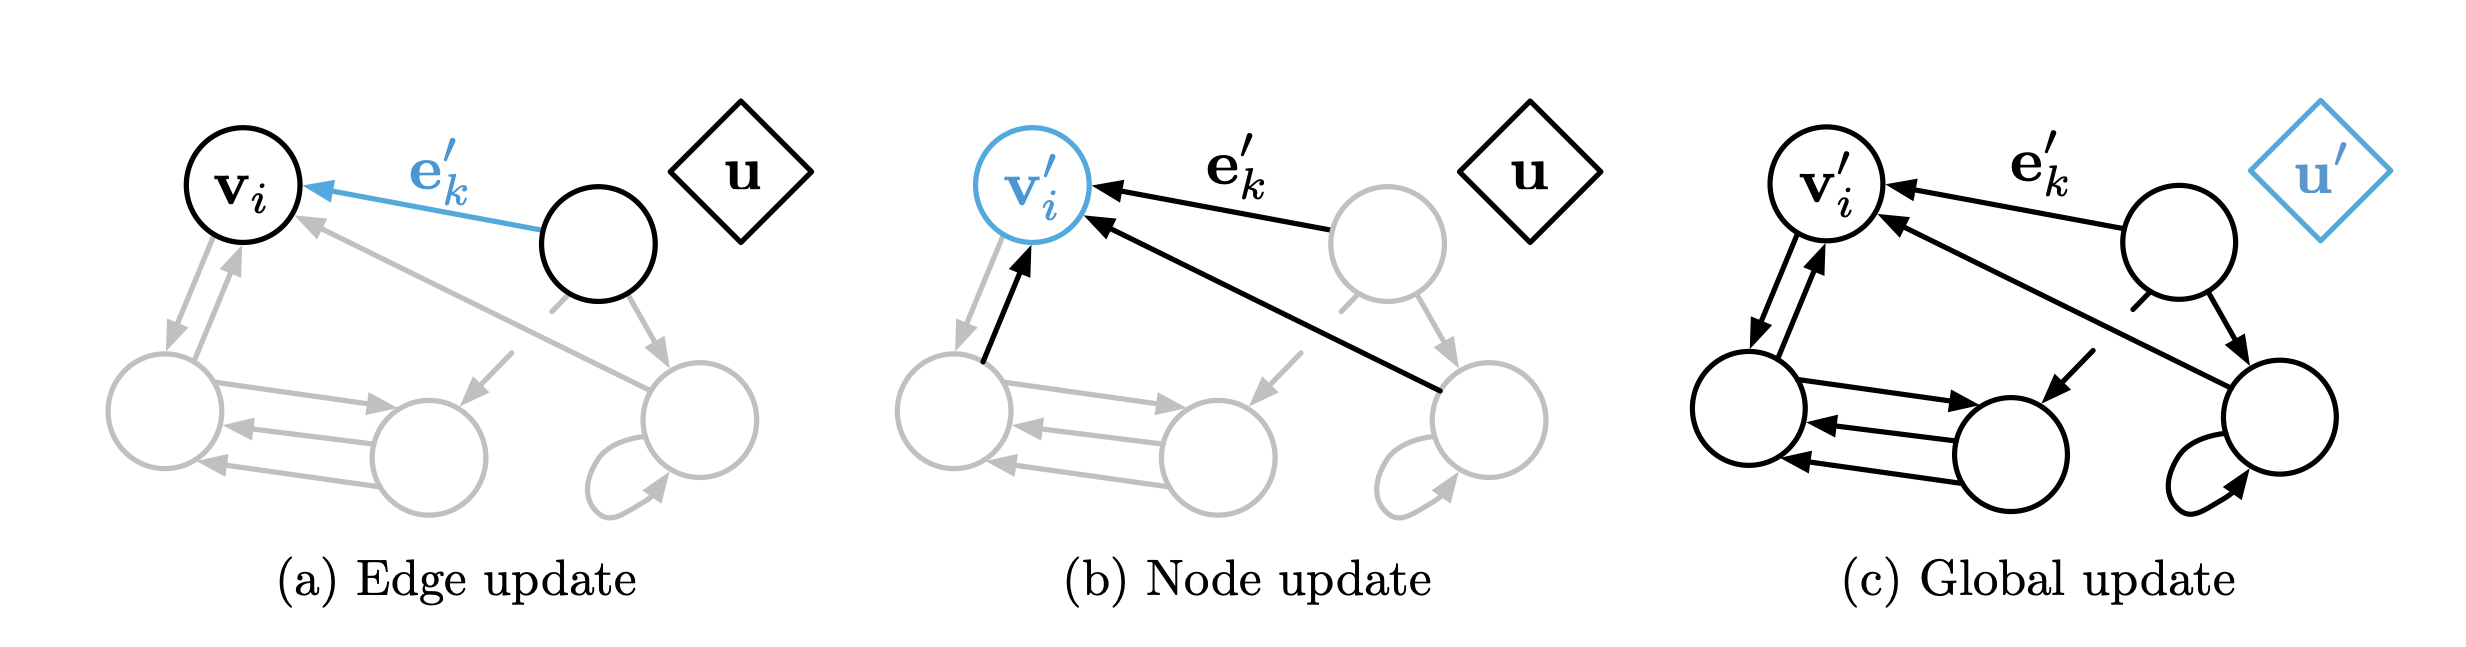

We didn't tell you what "Update" and "Aggregate" exactly mean because they depend on the context of problem you are studying.

**Learning tasks**: GNN can be trained to do regression or classification on $u$, $v_i$, and $e_{ij}$. Here are few examples: 

*   Protein structure --> $e_{ij}$ classification 
*   Bandgap of a crystal --> $u$ regression
*   Spin configuration of Ising model --> $v_i$ classification 

For more information on Graph Neural Networks, see [this](https://arxiv.org/pdf/1806.01261.pdf) review paper (the above image was taken from there) or [this](https://www.section.io/engineering-education/an-introduction-to-graph-neural-network/) blog post (a bit more intuitve/less math heavy).

In [12]:
# Convert to graphs
featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
graph_data = featurizer.featurize(smiles_only)

In [13]:
# Now our data is represented as a deepchem graph objects
print(graph_data[0])

# Building Models with DeepChem
Now we are going to look at how we can use DeepChem to build models for predicitng the properties of our molecules. As the name might suggest, DeepChem is especially useful for doing deep learning on chemistry data. Accordingly, DeepChem makes it easy to incorporate TensorFlow (as well as other deep learning frameworks) into the DeepChem workflow. 

## Deep Learning with Fingerprints
Below, we will build a DeepChem model the Keras Sequential class and TensorFlow to predict the solubility of a molecule in water using its chemcial finge. Of course, we could also just train a Keras model directly on the fingerprint vectors themselves, but using DeepChem's wrapper for Keras/TensorFlow along with a DeepChem dataset drastically simplifies the workflow.

In [14]:
# DeepChem allows us to automatically featurize our data when using the molnet
# module. Here we read the data in as ecfp fingerprints
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets

In [15]:
import tensorflow as tf 

# First we define a keras sequential model
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1)
])

# And now we wrap our model with KerasModel
model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss()) # we pass the model and a dc loss funciton

In [16]:
# Train and evaluate our model
model.fit(train_dataset, nb_epoch=50)

metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'mean_squared_error': 0.025233996015284043}
test set score: {'mean_squared_error': 0.6688736021967864}


Obviously there is a lot more customization that can happen here, but the main workflow for using DeepChem with TF/Keras is shown above. For more info, see [this](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/05_Creating_Models_with_TensorFlow_and_PyTorch.ipynb) tutorial and the [documentation](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#keras-models). 

## Graph Neural Networks
DeepChem also makes it easy to build graph neural networks using Keras/TF, as we will see below. But first, let's use one of the prebuilt models that comes with DeepChem...

In [17]:
# Now we import the same data but as graphs
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [18]:
# Just to supress output of warnings
import warnings
warnings.filterwarnings("ignore")

# This finds the number of tasks (ie things we are trying to predict) and then runs
# a regression model for each of those tasks (in our case just 1)
n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='regression')
model.fit(train_dataset, nb_epoch=50)

0.03488417863845825

In [19]:
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('Training set score:', model.evaluate(train_dataset, [metric], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric], transformers))

Training set score: {'mean_squared_error': 0.14037031327036248}
Test set score: {'mean_squared_error': 2.1104317283425007}


The graph neural network did much more poorly than our traditional neural network did on the fingerprints, but this was just using a stock model that comes with DeepChem. This model can be tuned fairly easily, and is only one of the models available in DeepChem for working with molecules as graphs. A full list of all the models implimented in DeepChem for Keras can be found [here](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#keras-models).

### Advanced/Optional Graph Neural Network Customization

Of course, we could also design our own model using TF/Keras. Let's design our own model to do something more sophisticated, like estimating qualitative toxicology measures of molecules included in the tox21 dataset. We are going to apply the following layers from DeepChem.

-  `GraphConv` layer: This layer implements the graph convolution. The graph convolution combines per-node feature vectures in a nonlinear fashion with the feature vectors for neighboring nodes.  This "blends" information in local neighborhoods of a graph.

- `GraphPool` layer: This layer does a max-pooling over the feature vectors of atoms in a neighborhood. You can think of this layer as analogous to a max-pooling layer for 2D convolutions but which operates on graphs instead. 

- `GraphGather`: Many graph convolutional networks manipulate feature vectors per graph-node. For a molecule for example, each node might represent an atom, and the network would manipulate atomic feature vectors that summarize the local chemistry of the atom. However, at the end of the application, we will likely want to work with a molecule level feature representation. This layer creates a graph level feature vector by combining all the node-level feature vectors.

Apart from this we are going to apply standard neural network layers such as [Dense](https://keras.io/api/layers/core_layers/dense/), [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) and [Softmax](https://keras.io/api/layers/activation_layers/softmax/) layer.

In [20]:
# Import the new dataset 
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets
n_tasks = len(tasks) # This is 12 because we have 12 variables to classify

from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers

batch_size = 100

# Define a Graph Convolution Model
class MyGraphConvModel(tf.keras.Model):

  def __init__(self):
    super(MyGraphConvModel, self).__init__()
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(256, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(n_tasks*2)
    self.logits = layers.Reshape((n_tasks, 2))
    self.softmax = layers.Softmax()

  def call(self, inputs):
    gc1_output = self.gc1(inputs)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + inputs[1:])

    gc2_output = self.gc2([gp1_output] + inputs[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + inputs[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + inputs[1:])

    logits_output = self.logits(self.dense2(readout_output))
    return self.softmax(logits_output)


We can now see more clearly what is happening.  There are two convolutional blocks, each consisting of a `GraphConv`, followed by batch normalization, followed by a `GraphPool` to do max pooling.  We finish up with a dense layer, another batch normalization, a `GraphGather` to combine the data from all the different nodes, and a final dense layer to produce the global output. 

Let's now create the DeepChem model which will be a wrapper around the Keras model that we just created. We will also specify the loss function so the model know the objective to minimize.

In [21]:
# Make apply the DeepChem wrapper 
model = dc.models.KerasModel(MyGraphConvModel(), loss=dc.models.losses.CategoricalCrossEntropy())

One more issue we need to address first. Our data is currently being passed in as a ConvMol Python object, but models expect arrays of numbers as their inputs, not Python objects. We must convert the ConvMol objects into the particular set of arrays expected by the GraphConv, GraphPool, and GraphGather layers. Fortunately, the ConvMol class includes the code to do this, as well as to combine all the molecules in a batch to create a single set of arrays.

The following code creates a Python generator that given a batch of data generates the lists of inputs, labels, and weights whose values are Numpy arrays. atom_features holds a feature vector of length 75 for each atom. The other inputs are required to support minibatching in TensorFlow. degree_slice is an indexing convenience that makes it easy to locate atoms from all molecules with a given degree. membership determines the membership of atoms in molecules (atom i belongs to molecule membership[i]). deg_adjs is a list that contains adjacency lists grouped by atom degree. For more details, check out [this](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/06_Introduction_to_Graph_Convolutions.ipynb) tutorial.

In [22]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
import numpy as np

# Create data generator to convert ConvMol to input for TF
def data_generator(dataset, epochs=1):
  for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, epochs,
                                                                   deterministic=False, pad_batches=True)):
    multiConvMol = ConvMol.agglomerate_mols(X_b)
    inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
      inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
    labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, n_tasks, 2)]
    weights = [w_b]
    yield (inputs, labels, weights)


Now, we can train the model using fit_generator(generator) which will use the generator we've defined to train the model. We will also evaluate its performance using the ROC AUC score.

In [23]:
# Fit and evaluation the model
import warnings
warnings.filterwarnings("ignore")

model.fit_generator(data_generator(train_dataset, epochs=50))

metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('Training set score:', model.evaluate_generator(data_generator(train_dataset), [metric], transformers))
print('Test set score:', model.evaluate_generator(data_generator(test_dataset), [metric], transformers))

Training set score: {'roc_auc_score': 0.8286609637090355}
Test set score: {'roc_auc_score': 0.6193519177075352}


As we can see, this model actually did quite well!

# Post Section Quetions
1) Explain the advantages and disadvantages of encoding molecules as fingerprints in a couple sentences. \\

One advantage is that it allows for the fingerprint to be comparable across different molecules due to its standardization of size and features. This allows for an easy way to see what molecules are similar and how to teach a model. The major highlighted disadvantage is that because of the standardizaton information about specific molecles can get lost. With lost information, two different molecules can have similar identifiable features via a fingerprint but cannot actually be identified because those key differences may not be captured. 

2) Look over [these](https://github.com/deepchem/deepchem/tree/master/examples/tutorials) DeepChem tutorials and pick one that interests you. Read through the tutorial and give a few sentence summary.

I chose the "Creating Models with TensorFlow and PyTorch" tutorial. This tutorial shows you how to integrate the deepchem models wth different tensorflow and pytorch APIs, such as building or evaluating models. It goes through how to wrap each built model, and what are the expected outputs. It also moves into more complicated integrations that allow you to specialize your model further with regards to choices on loss and how to pick and choose items from either DeepChem or PyTorch or TensorFlow. 